## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Видим нули в столбце num_orders, построим гистограмму для того, чтобы выяснить - естественные ли они, или это аномалии.

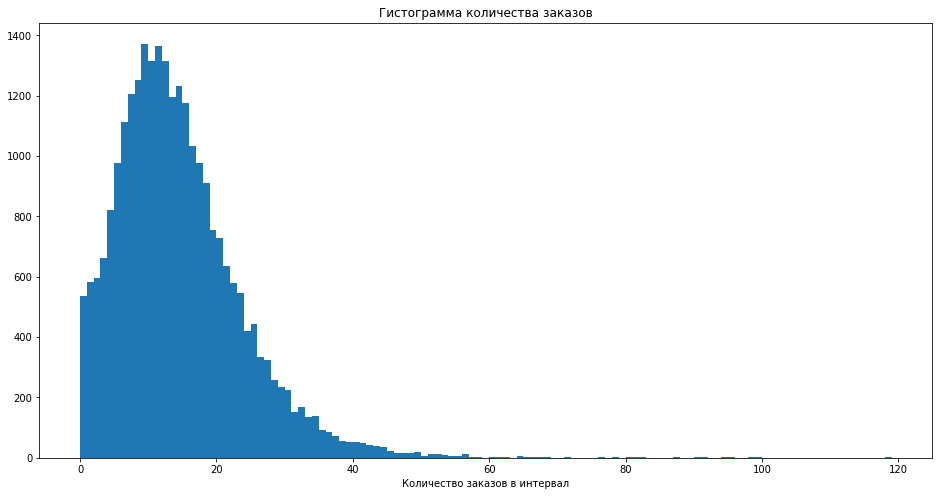

In [5]:
fig = plt.figure(figsize=(16,8))
ax = plt.hist(df['num_orders'], bins = 119)
plt.xlabel('Количество заказов в интервал')
plt.title("Гистограмма количества заказов")
plt.show()

Видим, что гистограмма имеет форму распределения Пуассона, значит, всё в порядке, оставляем нули в покое.

Посмотрим, в порядке ли хронологии расположены данные:

In [6]:
df.index.is_monotonic

True

In [7]:
print("Начало наблюдения:", df.index.min())
print("Конец наблюдения:", df.index.max())

Начало наблюдения: 2018-03-01 00:00:00
Конец наблюдения: 2018-08-31 23:50:00


В распоряжении у нас есть данные за с марта по август 2018 года. Пропусков в данных нет, поехали тогда их анализировать-сэмплировать.

# 2. Анализ

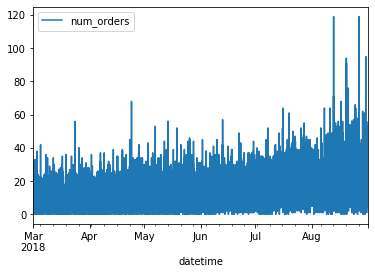

In [8]:
df.plot()

Исходя из предоставленных данных - годовая сезонность нам недоступна. Однако, унывать нечего, если есть паттерн, то он найдётся и в меньшем периоде времени'

Видим, что каждый месяц количество заказов в сервисе - растёт. Говорить о железобетонной закономерности преждевременно из-за маленького объёма данных, которые у нас есть для анализа. Поехали дальше.

Text(0, 0.5, 'Значения ряда')

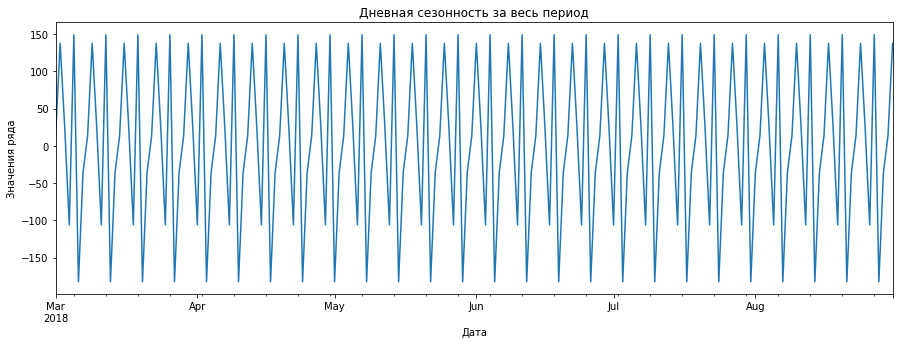

In [9]:
df_day = df.resample('1D').sum()

decomposed = seasonal_decompose(df_day['num_orders'])

plt.figure(figsize=(15, 5))
plt.subplot(111)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Дневная сезонность за весь период')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

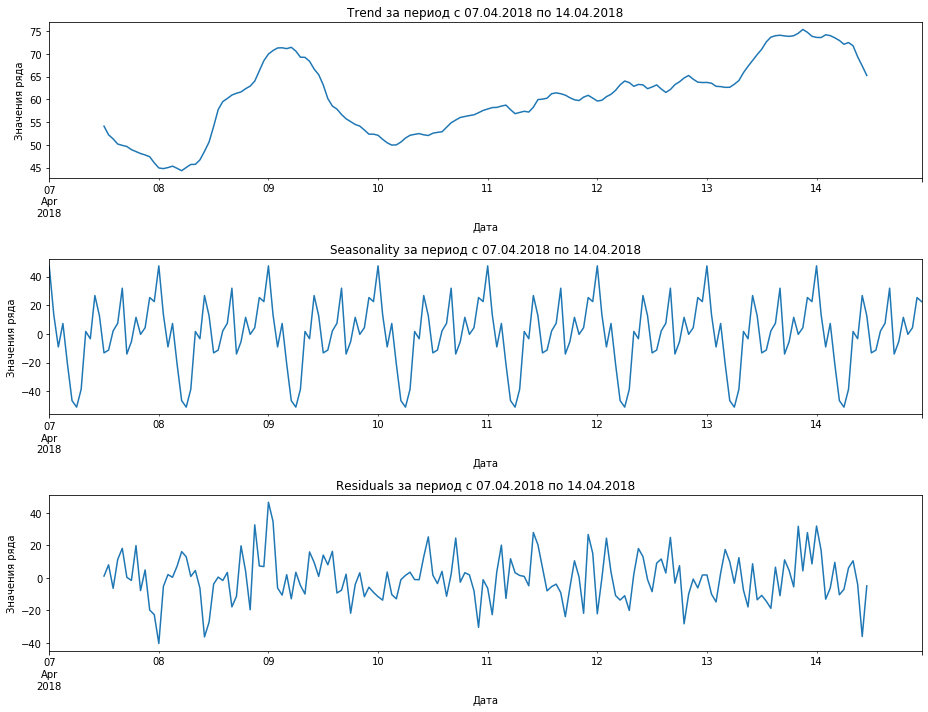

In [10]:
df_hour = df['2018-04-7':'2018-04-14'].resample('1H').sum()

decomposed = seasonal_decompose(df_hour['num_orders'])

plt.figure(figsize=(13, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за период с 07.04.2018 по 14.04.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality за период с 07.04.2018 по 14.04.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals за период с 07.04.2018 по 14.04.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.tight_layout()

Наблюдаем еженедельную сезонность: пики приходятся на середину недели и вскр-пн. В течение дня - высокие показатели идут на вечер. Делать какие-то выводы на тему, почему высокие показатели приходятся именно на этот период можно, но такие предположения будут казаться больше пальцем в небо, нежели дейтсвительно отрефлексированными заключениями: ведь мы не знаем, например, данные какого города нам предоставлены - миллионника или города с 130 тыс. жителями на Дальнем Востоке России, от этого зависят многие входные данные, начиная от интенсивности пассажиропотока, его центробежности (или наоборот) и так далее. Поэтому просто скажем, что это так - как оно есть, и не ошибёмся. 

# 3. Обучение

Для успешного обучения добавим признаки, сделаем это через функцию make_features()

In [11]:
df = df.resample('1H').sum()

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 24):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Добавили к данным такие признаки: месяц, день и день недели; отстающие значения; скользящее среднее. Поглядим, что вышло.

In [13]:
make_features(df, 6, 7)
df.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.142857
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.571429


Разделим выборку, с тестом размером 10% от исходных данных, как и было указано к требованиям проекта

In [14]:
train_and_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_and_valid, shuffle=False, test_size=0.1)
train_and_valid = train_and_valid.dropna()
train = train.dropna()

In [15]:
features_train_and_valid = train_and_valid.drop(['num_orders'], axis=1)
target_train_and_valid = train_and_valid['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [16]:
print(features_train.index[features_train.shape[0]-1])
print(features_test.index[0])

2018-07-27 23:00:00
2018-08-13 14:00:00


### Логрег

In [17]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
RMSE_lr = mean_squared_error(target_valid, predictions_lr) ** .5
print('RMSE линейной регрессии {:.1f}'.format(RMSE_lr))

RMSE линейной регрессии 34.5


Честно говоря, такой показатель RMSE заставляет задуматься, что дело не в отличной работе автора, а ровно наоборот - закравшейся ошибке. Тем не менее, проджолжим скользить по другим моделям, вдруг там будет больше толку.

### Модель решающего дерева с выбором гиперпараметров

In [18]:
min_RMSE = 10 ** 6
for depth in range(1, 20):
    for split in range(2, 5):
        for leaf in range(1, 20):
            model_tree = DecisionTreeRegressor(random_state=123456, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            model_tree.fit(features_train, target_train)
            predictions_tree = model_tree.predict(features_valid)
            RMSE_tree = mean_squared_error(target_valid, predictions_tree) ** .5
            print("max_depth =", depth, "min_samples_split =", split, "min_samples_leaf =", leaf, ": ", RMSE_tree)
            if min_RMSE > RMSE_tree:
                min_RMSE = RMSE_tree
                tree_max_depth = depth
                tree_min_samples_split = split
                tree_min_samples_leaf = leaf
print('Наилучшая модель решающего дерева при гиперпараметрах:')
print('max_depth', tree_max_depth)
print('min_samples_split', tree_min_samples_split)
print('min_samples_leaf', tree_min_samples_leaf)
RMSE_tree = min_RMSE
print('RMSE решающего дерева {:.1f}'.format(RMSE_tree))

max_depth = 1 min_samples_split = 2 min_samples_leaf = 1 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 2 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 3 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 4 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 5 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 6 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 7 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 8 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 9 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 10 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 11 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 12 :  50.95000067679147
max_depth = 1 min_samples_split = 2 min_samples_leaf = 13 :  

### Модель случайного леса с выбором гиперпараметров

In [19]:
min_RMSE = 10 ** 6
for estimators in range(5, 100, 5):
    model_forest = RandomForestRegressor(random_state=12345, n_estimators=estimators)
    model_forest.fit(features_train, target_train)
    predictions_forest = model_forest.predict(features_valid)
    RMSE_forest = mean_squared_error(target_valid, predictions_forest) ** 0.5
    print("n_estimators =", estimators, ": ", RMSE_forest)
    if min_RMSE > RMSE_forest:
        min_RMSE = RMSE_forest
        forest_n_estimators = estimators


min_RMSE = 10 ** 6
for depth in range(1, 30, 2):
    model_forest = RandomForestRegressor(random_state=12345, n_estimators=forest_n_estimators, max_depth=depth)
    model_forest.fit(features_train, target_train)
    predictions_forest = model_forest.predict(features_valid)
    RMSE_forest = mean_squared_error(target_valid, predictions_forest) ** 0.5
    print("max_depth =", depth, ": ", RMSE_forest)
    if min_RMSE > RMSE_forest:
        min_RMSE = RMSE_forest
        forest_max_depth = depth

print('Наилучшая модель случайного леса при гиперпараметрах n_estimators', forest_n_estimators, 'и max_depth', forest_max_depth)
RMSE_forest = min_RMSE
print('RMSE случайного леса {:.1f}'.format(RMSE_forest))

n_estimators = 5 :  36.84230690238394
n_estimators = 10 :  34.34370320377148
n_estimators = 15 :  33.4623005954317
n_estimators = 20 :  32.80672568239629
n_estimators = 25 :  33.104366288099875
n_estimators = 30 :  32.871081277716975
n_estimators = 35 :  32.767886758614324
n_estimators = 40 :  32.762087511950504
n_estimators = 45 :  32.710853196886994
n_estimators = 50 :  32.582550344236
n_estimators = 55 :  32.48053406634148
n_estimators = 60 :  32.438882263355076
n_estimators = 65 :  32.38110792692804
n_estimators = 70 :  32.42222069555538
n_estimators = 75 :  32.44350203231154
n_estimators = 80 :  32.382682019417864
n_estimators = 85 :  32.376349428173846
n_estimators = 90 :  32.32287728997065
n_estimators = 95 :  32.30668718787306
max_depth = 1 :  49.514586917622545
max_depth = 3 :  41.59547081876444
max_depth = 5 :  36.77274257704543
max_depth = 7 :  34.47996876225592
max_depth = 9 :  33.477239588247784
max_depth = 11 :  32.68952698583512
max_depth = 13 :  32.563593650363146
max_d

### LightGBM

In [20]:
model_LightGBM = lgb.LGBMRegressor(max_depth = 18, learning_rate=0.5)
model_LightGBM.fit(features_train, target_train)
predictions_LightGBM = model_LightGBM.predict(features_valid)
RMSE_LightGBM = mean_squared_error(target_valid, predictions_LightGBM) ** .5
print('RMSE LightGBM {:.1f}'.format(RMSE_LightGBM))

RMSE LightGBM 34.8


# 4. Тестирование

In [21]:

model_lr.fit(features_train_and_valid, target_train_and_valid)
predictions_lr = model_lr.predict(features_test)
RMSE_lr = mean_squared_error(target_test, predictions_lr) ** .5
print('RMSE линейной регрессии {:.1f}'.format(RMSE_lr))

RMSE линейной регрессии 45.3


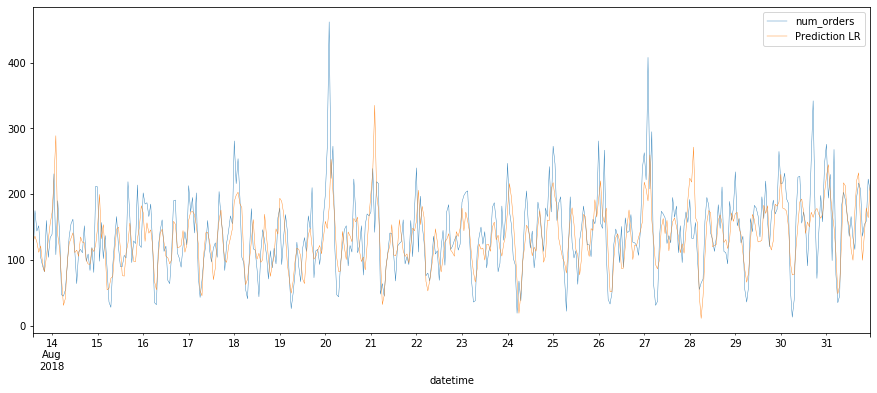

In [22]:
pd.concat([target_test, pd.DataFrame(predictions_lr, index = target_test.index, columns=['Prediction LR'])]
          , axis=1).plot(figsize=(15,6), linewidth=0.4);

In [23]:
model_tree = DecisionTreeRegressor(random_state=123456,
                                   max_depth=tree_max_depth,
                                   min_samples_split=tree_min_samples_split,
                                   min_samples_leaf=tree_min_samples_leaf)
model_tree.fit(features_train_and_valid, target_train_and_valid)
predictions_tree = model_tree.predict(features_test)
RMSE_tree = mean_squared_error(target_test, predictions_tree) ** .5
print('RMSE решающего дерева {:.1f}'.format(RMSE_tree))

RMSE решающего дерева 47.2


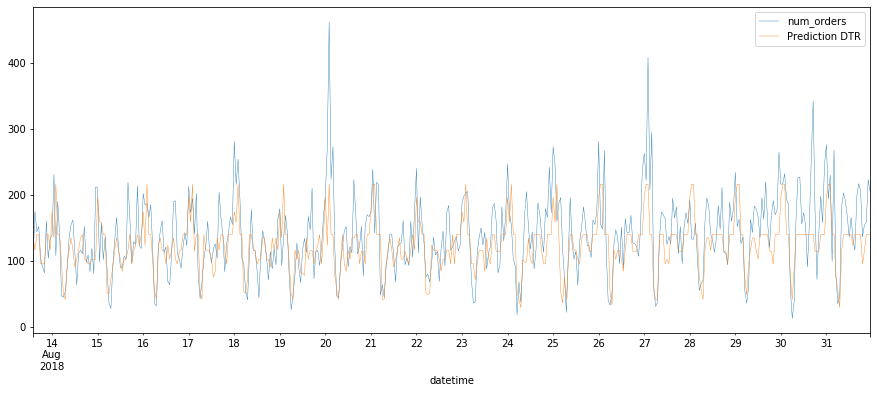

In [24]:
pd.concat([target_test, pd.DataFrame(predictions_tree, index = target_test.index, columns=['Prediction DTR'])]
          , axis=1).plot(figsize=(15,6), linewidth=0.4);

In [25]:
model_forest = RandomForestRegressor(random_state=12345,
                                      n_estimators=forest_n_estimators,
                                      max_depth=forest_max_depth)
model_forest.fit(features_train_and_valid, target_train_and_valid)
predictions_forest = model_forest.predict(features_test)
RMSE_forest = mean_squared_error(target_test, predictions_forest) ** .5
print('RMSE случайного леса {:.1f}'.format(RMSE_forest))

RMSE случайного леса 41.7


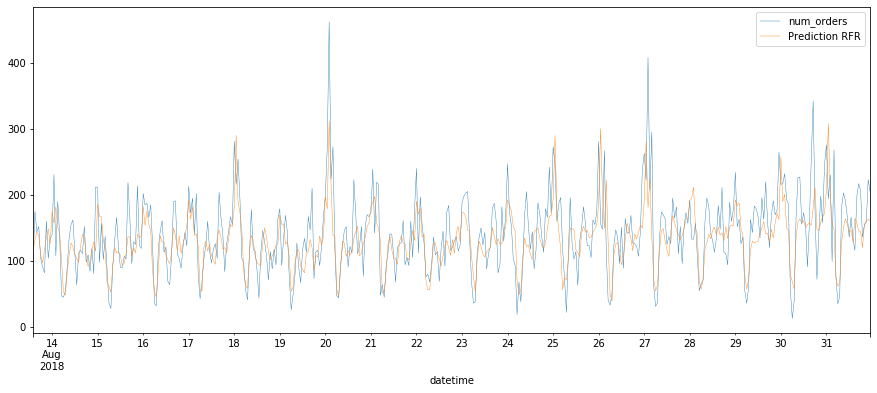

In [26]:
pd.concat([target_test, pd.DataFrame(predictions_forest, index = target_test.index, columns=['Prediction RFR'])]
          , axis=1).plot(figsize=(15,6), linewidth=0.4);

In [27]:
model_LightGBM = lgb.LGBMRegressor(max_depth = forest_max_depth, learning_rate=1)
model_LightGBM.fit(features_train_and_valid, target_train_and_valid)
predictions_LightGBM = model_LightGBM.predict(features_test)
RMSE_LightGBM = mean_squared_error(target_test, predictions_LightGBM) ** .5
print('RMSE LightGBM {:.1f}'.format(RMSE_LightGBM))

RMSE LightGBM 51.4


# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48